In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder("./dataset", transform=train_transform)

# split 70/15/15
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", dataset.classes)

Classes: ['Hawar', 'Karat', 'Sehat']


In [5]:
def build_model(model_name, num_classes):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError("Model not supported")
    return model.to(device)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validate
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")

In [7]:
# Optimizer, Scheduler
# optimizer_resnet = optim.Adam(resnet50.fc.parameters(), lr=1e-4, weight_decay=1e-4)
# sch_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min', patience=3, factor=0.5, verbose=True)

# optimizer_densenet = optim.Adam(densenet121.classifier.parameters(), lr=1e-4, weight_decay=1e-4)
# sch_dense = optim.lr_scheduler.ReduceLROnPlateau(optimizer_densenet, mode='min', patience=3, factor=0.5, verbose=True)

In [8]:
# Train
# train_resnet = train_model(resnet50, optimizer_resnet, sch_resnet, "resnet50", epochs=10)
# train_densenet = train_model(densenet121, optimizer_densenet, sch_dense, "densenet121", epochs=10)

# Save
# torch.save(train_resnet.state_dict(), "corn_resnet50.pth")
# print("Model saved as corn_resnet50.pth")
# torch.save(train_densenet.state_dict(), "corn_densenet121.pth")
# print("Model saved as corn_densenet121.pth")

In [9]:
def evaluate_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.show()


===== Training RESNET50 =====


d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Miniconda\envs\dl_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Train Loss: 1.0443 Acc: 0.5069 - Val Loss: 1.0482 Acc: 0.3696
Epoch 2/10 - Train Loss: 0.7203 Acc: 0.7742 - Val Loss: 0.7034 Acc: 0.7609
Epoch 3/10 - Train Loss: 0.5295 Acc: 0.8986 - Val Loss: 0.6693 Acc: 0.6957
Epoch 4/10 - Train Loss: 0.4530 Acc: 0.9032 - Val Loss: 0.4603 Acc: 0.8261
Epoch 5/10 - Train Loss: 0.3856 Acc: 0.8940 - Val Loss: 0.3992 Acc: 0.8913
Epoch 6/10 - Train Loss: 0.3394 Acc: 0.9309 - Val Loss: 0.3518 Acc: 0.8913
Epoch 7/10 - Train Loss: 0.3012 Acc: 0.9171 - Val Loss: 0.3348 Acc: 0.8913
Epoch 8/10 - Train Loss: 0.2794 Acc: 0.9355 - Val Loss: 0.2997 Acc: 0.9130
Epoch 9/10 - Train Loss: 0.3251 Acc: 0.8894 - Val Loss: 0.2864 Acc: 0.9348
Epoch 10/10 - Train Loss: 0.2278 Acc: 0.9493 - Val Loss: 0.2673 Acc: 0.9130
Training complete.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22452\559994869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Report:
              precision    recall  f1-score   support

       Hawar       1.00      0.95      0.98        21
       Karat       0.93      1.00      0.96        13
       Sehat       1.00      1.00      1.00        13

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47



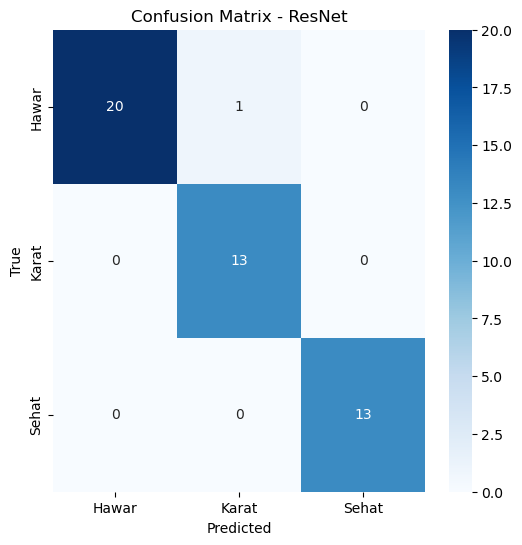


===== Training DENSENET121 =====


d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Miniconda\envs\dl_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Train Loss: 1.0827 Acc: 0.3594 - Val Loss: 1.0351 Acc: 0.3913
Epoch 2/10 - Train Loss: 0.8272 Acc: 0.7051 - Val Loss: 0.9117 Acc: 0.5870
Epoch 3/10 - Train Loss: 0.6696 Acc: 0.8157 - Val Loss: 0.7166 Acc: 0.8696
Epoch 4/10 - Train Loss: 0.5460 Acc: 0.8986 - Val Loss: 0.6267 Acc: 0.8043
Epoch 5/10 - Train Loss: 0.4758 Acc: 0.8756 - Val Loss: 0.5321 Acc: 0.8261
Epoch 6/10 - Train Loss: 0.4078 Acc: 0.9171 - Val Loss: 0.4598 Acc: 0.8913
Epoch 7/10 - Train Loss: 0.3915 Acc: 0.9078 - Val Loss: 0.4196 Acc: 0.8478
Epoch 8/10 - Train Loss: 0.3460 Acc: 0.9309 - Val Loss: 0.3716 Acc: 0.9348
Epoch 9/10 - Train Loss: 0.3141 Acc: 0.9263 - Val Loss: 0.3482 Acc: 0.8913
Epoch 10/10 - Train Loss: 0.3367 Acc: 0.8894 - Val Loss: 0.3137 Acc: 0.9130
Training complete.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22452\559994869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Report:
              precision    recall  f1-score   support

       Hawar       1.00      1.00      1.00        21
       Karat       1.00      1.00      1.00        13
       Sehat       1.00      1.00      1.00        13

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



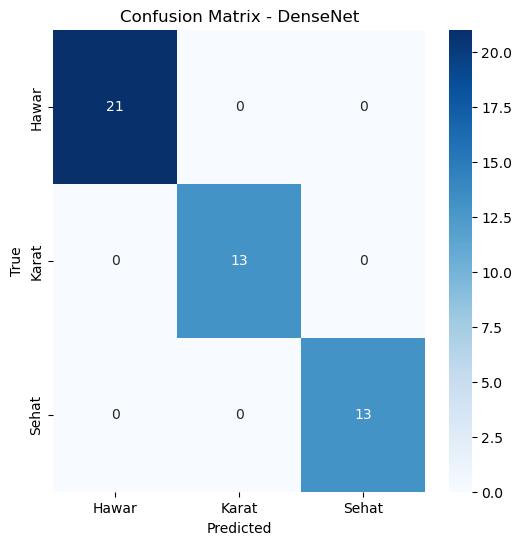

In [10]:
for arch in ["resnet50", "densenet121"]:
    print(f"\n===== Training {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=4)
    evaluate_model(model, f"best_{type(model).__name__}.pth")